In [1]:
import networkx as nx
import numpy as np
from karateclub.graph_embedding import Graph2Vec

Number of nodes: 34
Number of edges: 78
Nodes: [(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]

Edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 

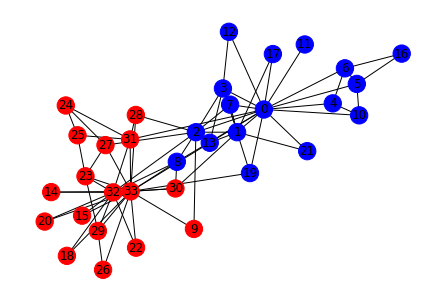

In [2]:
G = nx.karate_club_graph()
colormap = ["blue" if data["club"] == "Mr. Hi" else "red" for _, data in G.nodes(data=True)]
nx.draw(G, with_labels=True, node_color=colormap)
print("Number of nodes:", G.order())
print("Number of edges:", G.size())
print("Nodes:", G.nodes(data=True), end="\n\n")
print("Edges:", G.edges,end="\n\n")

Let's modify the karate club graph just a bit, adding three more edges. The resulting graph is our G'.

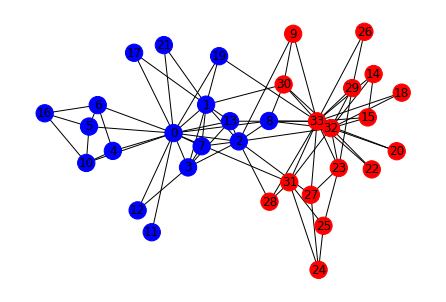

In [3]:
G_prime = G
G_prime.add_edges_from([(16,10), (30, 9), (14, 15)])
nx.draw(G_prime, with_labels=True, node_color=colormap)

Let's also use a random binomial graph (Erdõs-Rényi) to compare with the Karate Club Graph. This random graph also has 34 nodes and
each pair of nodes has 20% of chance to link with one another.

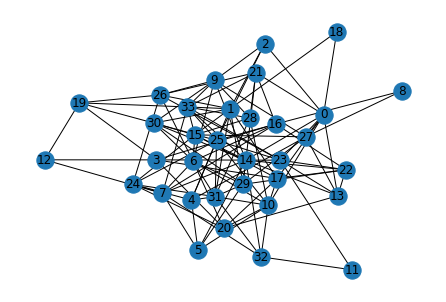

In [4]:
G_binomial = nx.binomial_graph(n=34,p=0.2)
nx.draw(G_binomial, with_labels=True)

# Graph Features

Goal: find features that can represent the structure of an entire graph.

<b>Kernel methods</b> are widely-used for traditional ML graph-level prediction. The idea is to design kernels instead of feature vectors.

* Kernel K(G,G') returns a real value that measures the simlarity between data.
* Kernel matrix K = (K(G,G')) must alaways have positive eigenvalues.
* There exists a feature (vectorial) representation phi(.) such that K(G,G') = phi(G).T @ phi(G')
* Once the kernel is defined, classical ML models such as Kernel SVMs can be used to make predictions.  

## Graph Kernels

Measure similarity between two graphs.

Goal: design a graph feature vector phi(G).

Key idea: Bag-of-Words for graphs. Recall that BoW uses the word counts as features for documents (no ordering considered). The idea is to extend this to graphs by counting different types of structures as if they were words in a document. A simple idea is to count node degrees.

## Bag of Node Degrees

In [5]:
bnd = np.array(list(dict(G.degree).values()))
print("Bag of Node Degrees for the Karate Graph:",bnd)
bnd = bnd/np.sum(bnd) # normalize

bnd_prime = np.array(list(dict(G_prime.degree).values()))
print("Bag of Node Degrees for the Prime Graph:", bnd_prime)
bnd_prime = bnd_prime/np.sum(bnd_prime)

bnd_binomial = np.array(list(dict(G_binomial.degree).values()))
print("Bag of Node Degrees for the Binomial Graph:",bnd_binomial)
bnd_binomial = bnd_binomial/np.sum(bnd_binomial)


kernel_prime = np.dot(bnd.T, bnd_prime)
print("\nKernel between Karate Club and Prime Graph:", kernel_prime)

kernel_binomial = np.dot(bnd.T, bnd_binomial)
print("Kernel between Karate Club and Binomial Graph:", kernel_binomial)


if kernel_prime > kernel_binomial:
    print("\nG' is more similar to the G than the binomial graph.")

Bag of Node Degrees for the Karate Graph: [16  9 10  6  3  4  4  4  5  3  4  1  2  5  3  3  3  2  2  3  2  2  2  5
  3  3  2  4  3  4  5  6 12 17]
Bag of Node Degrees for the Prime Graph: [16  9 10  6  3  4  4  4  5  3  4  1  2  5  3  3  3  2  2  3  2  2  2  5
  3  3  2  4  3  4  5  6 12 17]
Bag of Node Degrees for the Binomial Graph: [ 9 10  4  6  6  5 10  8  2  8  9  2  3  6 12  9  7  7  2  5  6  6  6  8
  7  9  7  7  6  8  8  9  5 10]

Kernel between Karate Club and Prime Graph: 0.04755372656607224
Kernel between Karate Club and Binomial Graph: 0.031529374201787995

G' is more similar to the G than the binomial graph.


### Graphlet Kernel

Key idea: count the number of different graphlets in a graph.

<b>Note:</b> The definition of graphlets here is slightly different from the one described at the node-level features notebook, here:

* Nodes in graphlets do not need to be connected (allows for isolated nodes).
* Graphlets are not rooted.

<b>How it works:</b>
* Let Gk = (g1, g2, ..., gnk) be a list of graphlets of size k.

* For k = 3 we have 4 types of graphlets: all nodes connected, all nodes connected but one, only two nodes connected and no nodes connected.
for k = 4 there are 11 graphlets and so on.

* Given a graph G and a graphlet list Gk = (g1, g2, ..., gnk), define the graphlet count vector F_G in real^nk as the count of each graphlet gi in G, for i = 1 up to nk.

<b>Computing the kernel</b>

* Given two graphs, G and G', the graphlet kernel is computed as K(G,G') = F_G.T @ F_G'

* Problem: if G and G' have different sizes, this will skew the value -> Need to normalize each feature vector by: h_H = F_G/sum(F_G)

<b> Limitations </b>

* Counting graphlets is very computiationally expensive. Counting size-k graphlets for graphs with size n takes O(n^k), since subgraph isomorphism test (judging whether a graph is a subgraph of another graph) is NP-hard.


### Weisfeiler-Lehman Kernal or Color Refinement

Goal: design an efficient graph feature descriptor of phi(G).

Idea: use neighborhood structure to iteratively enrich node vocabulary. It is a generalized version of bag of node degrees, since bag of node degrees are one-hop neighboorhood information.

<b>Color Refinement</b>

Given a graph G = (V, E), a Hash table H and a feature vector c.

1. Assign an initial color to each node V - all the nodes start with the same color.

Loop K times:

2. For each node v, accumulate the colors of v's neighbors. Each node v will have (current_color, [neighbor_colors])
3. Assign new colors for each combination of (current_color, [neighbor_colors]) and store it in T. T will have entries like key: (color, [colors]) -> value: new_color.
4. For each color i, count the number of nodes v that have the color i and store it in c[i].
5. Assign these new colors for each node v in G based on their mapping in T.
6. Repeat from step 2.

After K steps of color refinement, c summarizes the structure of K-hop neighborhood.

In [6]:
# Disclaimer: this is not the Weisfaler-Lehman method exacly, it 
# is actually a graph embedding method, but it uses the WL method underneath.

wl_model = Graph2Vec(attributed=False)
wl_model.fit([G, G_prime, G_binomial])
embeddings = wl_model.get_embedding()
print("Graph embedding shape:", embeddings.shape)
print("Graph embedding:", embeddings)

Graph embedding shape: (3, 128)
Graph embedding: [[ 6.3080546e-03  7.3775141e-03  6.2427549e-03 -5.9967083e-03
  -6.6309245e-03 -3.5864485e-03 -3.3581555e-03  3.5976653e-03
  -5.2786311e-03 -6.6389944e-03 -3.6471365e-03  7.6111830e-03
  -3.6524411e-03  1.1581471e-03  6.9329031e-03  3.3956135e-03
  -7.3697109e-04  7.3310719e-03 -4.6819607e-03  4.3338216e-03
   3.1433201e-03 -2.7682320e-03 -7.0072559e-04 -6.9628931e-03
   2.4031124e-05 -2.0925489e-03  7.7888351e-03 -3.7398401e-03
  -5.3008324e-03  8.8042894e-04 -6.1426777e-03 -6.2652896e-03
  -5.1237433e-03 -4.7991304e-03 -3.4274668e-03 -1.5351267e-03
  -1.9546871e-03  4.5374841e-03  5.3918571e-03 -3.5768189e-03
  -4.9899258e-03  6.4157398e-04 -3.4998213e-03  1.0540519e-05
   5.6652161e-03  3.0644969e-03 -4.2341771e-03 -9.9540467e-04
   1.1516891e-04 -6.3384711e-03  7.7800392e-03  6.5276502e-03
  -2.0990819e-05  4.5808852e-03  3.5572399e-03  6.8358863e-03
   2.8504145e-03 -7.2728368e-03 -1.9479727e-03  2.8233116e-03
  -4.5508018e-04  3.8

In [7]:
print(f"Kernel between G and G prime: {embeddings[0] @ embeddings[1]:.16f}")
print(f"Kernal between G and G binomial: {embeddings[0] @ embeddings[2]:.16f}")

Kernel between G and G prime: 0.0000504283925693
Kernal between G and G binomial: -0.0000487501529278
